In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

import seaborn as sns
import torchmetrics.classification as tc

from functions.dl.convenience_functions import to_device, trialDir
from functions.dl.data_classes import SpectroDataset, CombinedSpectroDataset, SpectroDataLoader
from functions.dl.data_functions import splitDataset, load_data, load_model, train_model, getBestModel
from functions.dl.network_components import EarlyStopping, AudioToLogSpectrogram, AudioToMelSpectrogram, AudioToMFCCSpectrogram
from functions.processing.retrieval import loadPT

ray.init(ignore_reinit_error=True)
print("Ray is initialized!")

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-01-30 13:42:25,779	INFO worker.py:2007 -- Started a local Ray instance.


Ray is initialized!


f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


(pid=gcs_server) [2026-01-30 13:42:48,447 E 20356 2908] (gcs_server.exe) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


In [3]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-5, 1e-2),          # Learning rate between 1e-5 and 1e-2
    # "batch_size": tune.lograndint(8, 16), # for small batch testing
    "batch_size": tune.lograndint(32, 128),
    "nfft" : tune.choice([512, 1024, 2048, 4096, 8192]),
    # "scale" : tune.uniform(0.5, 4),
    "power" : tune.uniform(0.5, 4),
    "patience" : tune.choice([2, 3, 5, 7, 9]),
    "EarlyDelta" : tune.uniform(0.0015, 0.1),
    "epochs" : tune.randint(15, max_epochs),
    "l1" : tune.loguniform(0.0005, 0.004),
    "l2" : tune.loguniform(0.00075, 0.003),
    "nmels" : tune.randint(64, 256),
    "nmfcc" : tune.randint(32, 128)
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [92]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.choice([0.0001]),          # Learning rate between 1e-5 and 1e-2
    # "batch_size": tune.lograndint(8, 16), # for small batch testing
    "batch_size": tune.choice([16]),
    "nfft" : tune.choice([4096]),
    # "scale" : tune.uniform(0.5, 4),
    "power" : tune.choice([2]),
    "patience" : tune.choice([5]),
    "EarlyDelta" : tune.choice([0.1]),
    "epochs" : tune.choice([15]),
    "l1" : tune.choice([0.001]),
    "l2" : tune.choice([0.0015]),
    "nmels" : tune.choice([128]),
    "nmfcc" : tune.choice([64])
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [13]:
def getSamples(split : list, sizes : list = [None, None, None]):
    """
        Computes the indices for the datasets used in the dataloader. Intended to be used after the splitDataset method.

        Inputs:
            split : list - list containing indices of the train, test and val splits
            sizes : list - list containing the number of samples. Uses absolute samples when given an int, percentage for float <= 1 and all sample for None type

        Outputs: 
            samples : list - list containing the split indices
    """
    samples = []
    for idx, data in enumerate(split):
        data_indices = []
        if type(sizes[idx]) is int:
            data_indices = split[idx][:sizes[idx]]
        elif (type(sizes[idx]) is float and sizes[idx] <= 1.0):
            indices = round(len(split[idx])*sizes[idx])
            data_indices = split[idx][:indices]
        elif sizes[idx] is None:
            data_indices = split[idx]
        
        samples.append(data_indices)
        
    return samples

In [5]:
# File locations for the label files
dawn_file = "F:/Persönliches/Git/BioOTon/points_single.parquet"
xeno_file = "F:/Persönliches/Git/BioOTon/xeno_points_single.parquet"
augmented_file = "F:/Persönliches/Git/BioOTon/augmented_points_single.parquet"
# recording_path= "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_denoised"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_freq"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors"
# label_path="F:\\Persönliches\\Git\\BioOTon"

# The train - test - validation split
train_split_pct = 0.7
val_split_pct = 0.1
test_split_pct = 1.0 - train_split_pct - val_split_pct

# If and how many samples to take from the dataset
train_sample_size = 0.001
test_sample_size = 0.01
val_sample_size = 0.0001

# Load  dataset

# ds = SpectroDataset(recording_path, label_path, device = 'cuda', denoised = True, filtered=False)
ds = CombinedSpectroDataset(dawn_file, xeno_file, augmented_file, device = device, denoised = True, cut = True, aggregate_labels=True, sample = (False,60))

# Get samples and split the dataset
split = splitDataset(ds, test_split_size=val_split_pct, val_split_size=test_split_pct)
train_indices, test_indices, val_indices = getSamples(split, sizes = [train_sample_size, test_sample_size, val_sample_size])

(raylet) [2026-01-30 12:18:03,045 E 14484 20028] (raylet.exe) main.cc:1032: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Getting index 168193, F:\Persönliches\Git\BioOTon\augmented_data_denoised_cut\rc_cut_0_19562028_audio_dn.pt
Getting index 158268, F:\Persönliches\Git\BioOTon\augmented_data_denoised_cut\wn_cut_0_22478947_audio_dn.pt
Getting index 171792, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_2_26263934_audio_dn.pt
Getting index 104151, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_2_26157508_audio_dn.pt
Getting index 104547, F:\Persönliches\Git\BioOTon\augmented_data_denoised_cut\wn_cut_0_22762449_audio_dn.pt
Getting index 182866, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_2_27729562_audio_dn.pt
Getting index 115777, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_1_23862388_audio_dn.pt
Getting index 197475, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_1_26268987_audio_dn.pt
Getting index 73245, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_2_22642759_audio_dn.pt
Getting index 163216, F:\Persönliches\Git\BioOTon\augmented

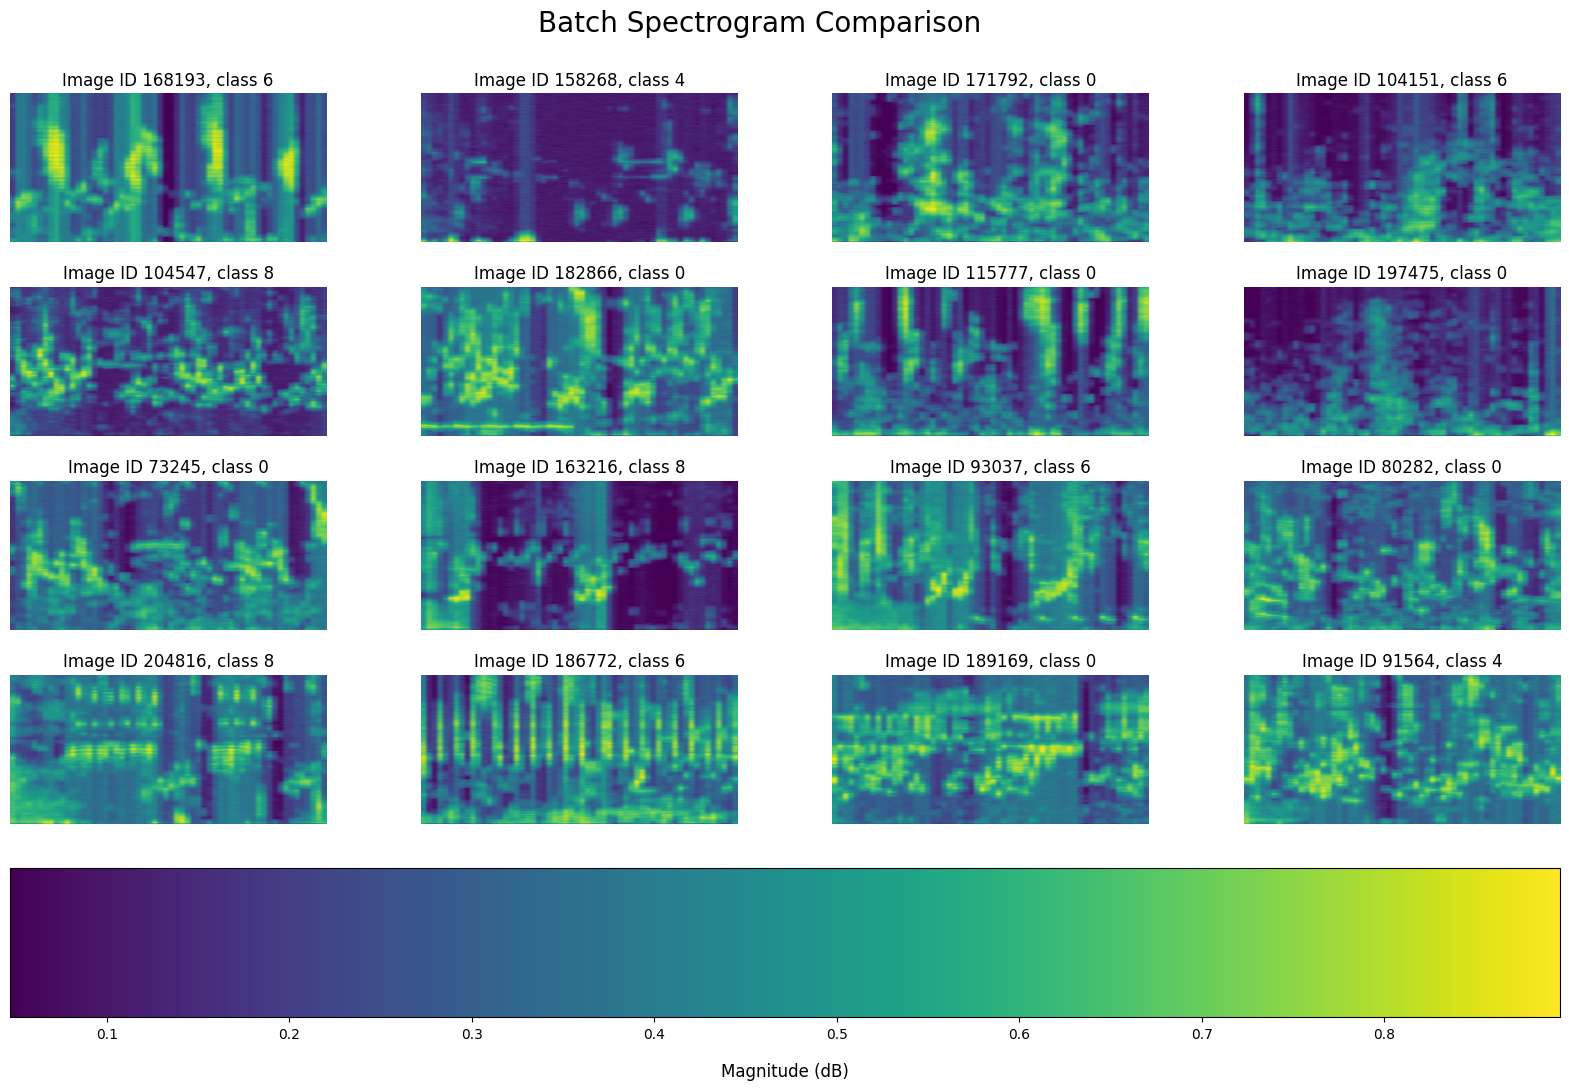

In [16]:
import matplotlib.gridspec as gridspec
config["batch_size"]=16
# Load data
train_dataloader, val_dataloader = load_data(config, ds, split = split, clip_length=15)
batch = next(iter(train_dataloader))

fig = plt.figure(figsize=(20, 12))
    
# 3 rows, 7 columns
# Column index 3 is the "divider" for the colorbar
gs = gridspec.GridSpec(5, 4, figure=fig, 
                        width_ratios=[1, 1, 1, 1],
                        wspace=0.3, hspace=0.3)

fig.suptitle('Batch Spectrogram Comparison', fontsize=20, y=0.95)

atls = AudioToLogSpectrogram().to("cuda")

for i in range(batch[1].shape[0]):
    
    wav = batch[1][i]

    img_tensor = atls(wav).squeeze(0).squeeze(0)
    img = img_tensor.detach().cpu().numpy()

    row = i // 4
    col = i % 4

    ax_l = fig.add_subplot(gs[row, col])
    im = ax_l.imshow(img, aspect='auto', origin='lower', cmap='viridis')
    ax_l.axis('off')
    ax_l.set_title(f"Image ID {int(batch[0][i])}, class {int(batch[2][i])}")

# Set colorbar to middle of the plot
cbar_ax = fig.add_subplot(gs[4, :])
cbar = fig.colorbar(im, orientation='horizontal', cax=cbar_ax)

# Set the label below colorbar
cbar.ax.set_xlabel('Magnitude (dB)', fontsize=12, labelpad=15)

plt.show()

In [93]:
import importlib
import sys
_ = importlib.reload(sys.modules["functions"])
_ = importlib.reload(sys.modules["functions.dl.data_classes"])
_ = importlib.reload(sys.modules["functions.dl.data_functions"])
_ = importlib.reload(sys.modules["functions.dl.network_components"])
from functions.dl.data_classes import CombinedSpectroDataset
from functions.dl.network_components import NestedUNet
from functions.dl.data_functions import train_model

In [94]:
# Rayt[tune] parameters
concurrent_trials = 1

# File locations for the label files
dawn_file = "F:/Persönliches/Git/BioOTon/points_single.parquet"
xeno_file = "F:/Persönliches/Git/BioOTon/xeno_points_single.parquet"
augmented_file = "F:/Persönliches/Git/BioOTon/augmented_points_single.parquet"
# recording_path= "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_denoised"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors_freq"# "F:\\Persönliches\\Git\\BioOTon\\AudioTensors"
# label_path="F:\\Persönliches\\Git\\BioOTon"

# The train - test - validation split
train_split_pct = 0.7
val_split_pct = 0.1
test_split_pct = 1.0 - train_split_pct - val_split_pct

# If and how many samples to take from the dataset
train_sample_size = 0.001
test_sample_size = 0.001
val_sample_size = 0.0001

# Load  dataset

# ds = SpectroDataset(recording_path, label_path, device = 'cuda', denoised = True, filtered=False)
ds = CombinedSpectroDataset(dawn_file, xeno_file, augmented_file, device = device, denoised = True, cut = True, sample = (False,15))

# Get samples and split the dataset
split = splitDataset(ds, test_split_size=val_split_pct, val_split_size=test_split_pct)
train_indices, test_indices, val_indices = getSamples(split, sizes = [train_sample_size, test_sample_size, val_sample_size])


trainable_with_parameters = tune.with_parameters(
    train_model, dataset=ds, num_classes = len(np.unique(ds.combined_encoded_labels)), spectro_mode = "atls", split = [train_indices, val_indices], clip_length=15 #train_size = int(np.floor(0.7 * len(ds))), val_size = int(np.floor(0.1 * len(ds)))# train_size=500, val_size=100
)

trainable_with_resources = tune.with_resources(
    trainable_with_parameters,
    resources={"cpu": 6/concurrent_trials, "gpu": 1/concurrent_trials, "accelerator_type:G":1/concurrent_trials}
)

optuna_search = OptunaSearch(
    metric=["loss", "accuracy"],
    mode=["min", "max"]
)

# Currently unused
hyperopt_search = HyperOptSearch(
    metric="loss",
    mode="min",  # Minimize loss
    # points_to_evaluate # Use when some good hyperparameters are known as initial values
)

asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=max_epochs,
    grace_period=10,
    brackets=1,
)

# Pass the search algorithm to Ray Tune
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    # tune_config=tune.TuneConfig(search_alg=hyperopt_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=2),
    tune_config=tune.TuneConfig(search_alg=optuna_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=concurrent_trials,),
    run_config=tune.RunConfig(storage_path='D:/ProgramFiles/RayResults', name="results")
)
tuner.fit()

(train_model pid=13892) Getting index 62398, F:\Persönliches\Git\BioOTon\augmented_data_denoised_cut\hb_cut_0_22505199_audio_dn.pt
(train_model pid=13892) Getting index 62403, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_2_22340783_audio_dn.pt
(train_model pid=13892) Getting index 62420, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_3_27439042_audio_dn.pt
(train_model pid=13892) Getting index 62408, F:\Persönliches\Git\BioOTon\augmented_data_denoised_cut\rc_cut_0_22671167_audio_dn.pt
(train_model pid=13892) Getting index 62516, F:\Persönliches\Git\BioOTon\XenoCanto_denoised_cut\cut_0_402994_audio_dn.pt
(train_model pid=13892) Getting index 62387, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_3_26786331_audio_dn.pt
(train_model pid=13892) Getting index 62412, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_2_27724706_audio_dn.pt
(train_model pid=13892) Getting index 62452, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_0_23207125

2026-01-30 14:29:16,588	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2026-01-30 14:29:16,617	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'D:/ProgramFiles/RayResults/results' in 0.0278s.


(train_model pid=17312) Got data
(train_model pid=17312) Got outputs
(train_model pid=17312) Got labels
(train_model pid=17312) Got loss
(train_model pid=17312) Got penalized
(train_model pid=17312) Got data
(train_model pid=17312) Got outputs
(train_model pid=17312) Got labels
(train_model pid=17312) Got loss
(train_model pid=17312) Got penalized
(train_model pid=17312) Got data
(train_model pid=17312) Got outputs
(train_model pid=17312) Got labels
(train_model pid=17312) Got loss
(train_model pid=17312) Got penalized
(train_model pid=17312) Got data
(train_model pid=17312) Got outputs
(train_model pid=17312) Got labels
(train_model pid=17312) Got loss
(train_model pid=17312) Got penalized
(train_model pid=17312) Got data
(train_model pid=17312) Got outputs
(train_model pid=17312) Got labels
(train_model pid=17312) Got loss
(train_model pid=17312) Got penalized
(train_model pid=17312) Got data
(train_model pid=17312) Got outputs
(train_model pid=17312) Got labels
(train_model pid=1731

2026-01-30 14:29:18,998	INFO tune.py:1041 -- Total run time: 130.83 seconds (128.42 seconds for the tuning loop).
2026-01-30 14:29:18,999	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="D:/ProgramFiles/RayResults/results", trainable=...)


(train_model pid=17312) Got data
(train_model pid=17312) Got outputs
(train_model pid=17312) Got labels
(train_model pid=17312) Got loss
(train_model pid=17312) Got penalized
(train_model pid=17312) 16  :  9
(train_model pid=17312) Got validation data
(train_model pid=17312) Got validation labels
(train_model pid=17312) Got validation outputs
(train_model pid=17312) Calculated validation loss
(train_model pid=17312) Calculated accuracy
(train_model pid=17312) [3,    10] loss: 53.945746 vloss: 3.696902


ResultGrid<[
  Result(
    metrics={'loss': 3.5532386302948, 'accuracy': 0.25},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_efe20a',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 3.425084114074707, 'accuracy': 0.25},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_94a90f',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 3.687873601913452, 'accuracy': 0.0},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_72f962',
    filesystem='local',
    checkpoint=None
  )
]>

In [13]:
model, df = getBestModel(return_df=True)

2026-01-15 16:03:07,338	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_73e38ce4: FileNotFoundError('Could not fetch metrics for train_model_73e38ce4: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_73e38c')


Best Hyperparameters: {'lr': 0.00010437337894045406, 'batch_size': 16, 'nfft': 4096, 'power': 2.944545263321588, 'patience': 9, 'EarlyDelta': 0.0037387477020960963, 'epochs': 24, 'l1': 0.001195137200137475, 'l2': 0.002874299044412903, 'nmels': 97, 'nmfcc': 43}


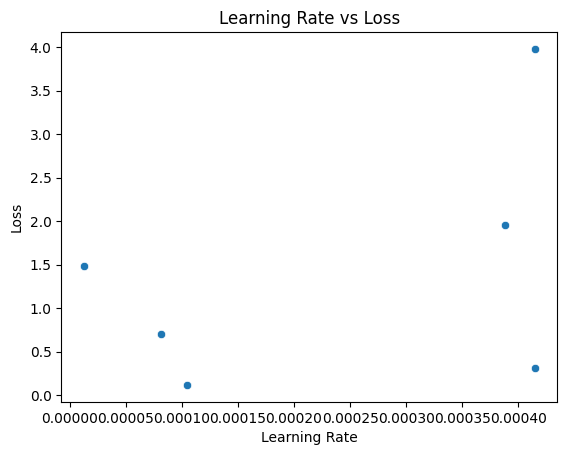

In [14]:
# Plot loss vs learning rate
sns.scatterplot(x="config/lr", y="loss", data=df)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

In [ ]:
%tensorboard --logdir runs/single_points/

In [15]:
train_indices, test_indices, val_indices = getSamples(split, sizes = [train_sample_size, test_sample_size, val_sample_size])

In [16]:
best_model_df = df[df["accuracy"] ==  df.sort_values("accuracy", ascending=False).iloc[0].accuracy]
if best_model_df.shape[0] > 1:
    best_model_df.sort_values("loss", ascending=True, inplace=True)
    
test_dataloader = SpectroDataLoader(ds, int(best_model_df.iloc[0]["config/batch_size"]), samples = test_indices, sample_rate = 16000, clip_length = 60, device = "cuda")

C:\Users\mfher\AppData\Local\Temp\ipykernel_20044\3548463851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_model_df.sort_values("loss", ascending=True, inplace=True)


2026-01-15 16:07:33,032	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_73e38ce4: FileNotFoundError('Could not fetch metrics for train_model_73e38ce4: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_73e38c')


Getting index 33891, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_0_23023598_audio_dn.pt
Getting index 33881, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_3_27833486_audio_dn.pt
Getting index 33876, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_2_22648080_audio_dn.pt
Getting index 33879, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_0_20349598_audio_dn.pt
Getting index 33889, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_1_28703655_audio_dn.pt
Getting index 33890, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_1_19411009_audio_dn.pt
Getting index 33888, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_2_25884137_audio_dn.pt
Getting index 33886, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_1_23439761_audio_dn.pt
Getting index 33883, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_0_27641571_audio_dn.pt
Getting index 33878, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_1_2

2026-01-15 16:07:33,283	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_73e38ce4: FileNotFoundError('Could not fetch metrics for train_model_73e38ce4: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_73e38c')


Getting index 33892, F:\Persönliches\Git\BioOTon\AudioTensors_denoised_cut\cut_1_23174537_audio_dn.pt
Best Hyperparameters: {'lr': 0.00010437337894045406, 'batch_size': 16, 'nfft': 4096, 'power': 2.944545263321588, 'patience': 9, 'EarlyDelta': 0.0037387477020960963, 'epochs': 24, 'l1': 0.001195137200137475, 'l2': 0.002874299044412903, 'nmels': 97, 'nmfcc': 43}


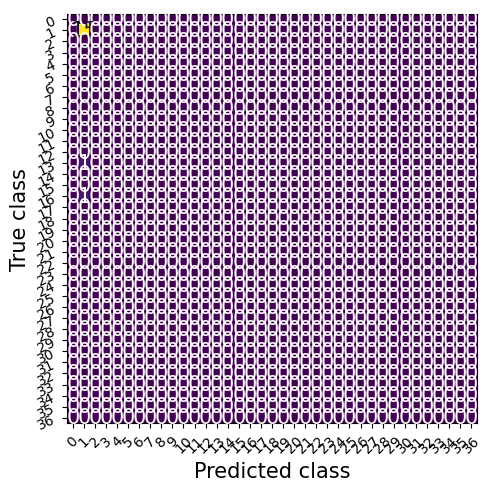

Recall of the custom cnn: tensor(0.3333, device='cuda:0')
F1-score of the custom cnn: tensor(0.3125, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.3333, device='cuda:0')


In [32]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        index, inputs, labels = data
        model = getBestModel().to(device)
        inp = model(inputs)

        indexes = torch.cat((indexes, index), 0).to(device)
        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0).to(device)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric_data = metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())

In [26]:
predicted_classes = torch.argmax(preds, dim=1)

is_correct = (predicted_classes == labs)

correct_indices = torch.where(is_correct)[0]
incorrect_indices = torch.where(~is_correct)[0]

print(f"Total samples: {len(labs)}")
print(f"Correct: {len(correct_indices)}")
print(f"Incorrect: {len(incorrect_indices)}")

Total samples: 17
Correct: 15
Incorrect: 2


In [28]:
import pandas as pd

results_df = pd.DataFrame({
    'True_Label': labs.cpu().numpy(),
    'Predicted_Label': predicted_classes.cpu().numpy(),
    'Is_Correct': is_correct.cpu().numpy()
})

# Show the first 10 mistakes
print("First 10 misclassifications:")
print(results_df[results_df['Is_Correct'] == False].head(10))

First 10 misclassifications:
    True_Label  Predicted_Label  Is_Correct
2           16                1       False
16          13                1       False


In [29]:
indexes

tensor([33880.], device='cuda:0')